# Notebook to process pcfusage.sh script


In [2]:
import sys
import json
import datetime

import pandas as pd

##########################################################
# Looking to build more interactive dashboard
# TODO: Allow interactive analysis and report generation
##########################################################
import ipywidgets as widgets
from IPython.display import display

##########################################################
# Sample files capture by the pcfusage.sh script
# TODO: Add this information in a metadata section
##########################################################

# BORGESCLOUD File
# file = "/Users/mborges/Tools/PCF/scripts/dev_foundation.json"
# capture_date = datetime.datetime(2018, 6, 26, 0, 0)
# diego_cell = {"number_of": 4, "vcpu": 4, "ram_gb": 32, "disk_gb": 32 }

# Sample 1
# file = "/Users/mborges/Tools/PCF/scripts/samples/sample1_foundation.json"
# capture_date = datetime.datetime(2018, 7, 2, 22, 0)
# diego_cell = {"number_of": 8, "vcpu": 8, "ram_gb": 32, "disk_gb": 256 }

# Sample 2
file = "/Users/bthelen/workspace/pcf-usage/pws_foundation.json"
capture_date = datetime.datetime(2018, 7, 11, 12, 0)
diego_cell = {"number_of": 6, "vcpu": 4, "ram_gb": 30.5, "disk_gb": 128 }

##########################################################
# Pre-processing of the foundation.json file
##########################################################

# Know system orgs we used to remove system applications from our analysis
system_orgs = ["system", "p-dataflow", "p-spring-cloud-services"]

# Foundation capacity from metadata section (currently data above)
total_vcpu = diego_cell['number_of'] * diego_cell['vcpu']
total_memory = diego_cell['number_of'] * diego_cell['ram_gb']

# Foundation json capture via script
with open(file, "r") as read_file:
    data = json.load(read_file)
    
# Creating dataframes for specific sections
# TODO: Can we not rely on the index? 
df_apps = pd.DataFrame(data[0]["apps"])
df_orgs = pd.DataFrame(data[1]["orgs"])
df_service_instances = pd.DataFrame(data[2]["service_instances"])
df_services = pd.DataFrame(data[3]["services"])
df_spaces = pd.DataFrame(data[4]["spaces"])
df_users = pd.DataFrame(data[5]["users"])

# Fix column names so we can merge
# TODO: Look inot fixing the pcfusage.sh script so this is not longer need
df_orgs = df_orgs.rename(columns = {"name":"org"})
df_spaces = df_spaces.rename(columns = {"name": "space", "org":"org_guid"})
df_apps = df_apps.rename(columns = {"space": "space_guid"})

# Merge spaces and orgs and create an non_system_spaces series
environments = pd.merge(df_spaces, df_orgs, on="org_guid")
non_system_spaces = (environments['org'].isin(system_orgs))

# Merge apps with spaces to get org and space names
apps = pd.merge(df_apps, environments, on="space_guid")

# Merge services with service instances
services = pd.merge(df_services, df_service_instances, on="service_guid")

# Non system applications
#non_system_apps = (apps['org'] != 'system') & (apps['org'] != 'p-dataflow')
system_apps = apps['org'].isin(system_orgs)
non_system_apps = ~apps['org'].isin(system_orgs)

# This is the core dataframe for applications
df_non_system_apps = apps[non_system_apps]


# Foundation by Numbers
## speed
Organizations can represent different business units, spaces environments where initial setup lead and process time are usually high. Services and buildpacks represents the middleware required to develop applications.

In [4]:
print ("Orgs: {}".format(len(df_non_system_apps['org'].unique())))
print ("Spaces: {}".format(len(df_non_system_apps['space'].unique())))
print ("Users: {}".format(len(list(df_users))))
print ("Services: {}".format(len(df_services['label'].unique())))
print ("Unique Applications: {}".format(len(df_non_system_apps['name'].unique())))
print ("Buildpacks: {}".format(len(df_non_system_apps['buildpack'].unique())))
print ("Containers: {}".format(df_non_system_apps['instances'].sum()))
print ("Service Instances: {}".format(len(df_service_instances['name'].unique())))



Orgs: 1
Spaces: 14
Users: 0
Services: 31
Unique Applications: 42
Buildpacks: 14
Containers: 48
Service Instances: 17


# Application Instance Memory in MB
## scalability
Statistics on memory usage by all customer applications. This can show scalability of PCF by comparing min and max memory sizes. 

In [5]:
df_non_system_apps['memory'].describe()


count      48.000000
mean     1010.666667
std       547.048612
min       128.000000
25%      1024.000000
50%      1024.000000
75%      1024.000000
max      4096.000000
Name: memory, dtype: float64

# Density
## savings
Number of containers per CPU and per vCPU. This can show infrastructure consolidation and savings

In [6]:
containers_per_cell = apps[non_system_apps]['instances'].sum() / diego_cell['number_of']
containers_per_vcpu = apps[non_system_apps]['instances'].sum() / total_vcpu
print ("Total system apps: {} and non system apps: {}".format(apps[system_apps]['instances'].sum(), apps[non_system_apps]['instances'].sum()))
print ("containers_per_cell of non system apps {}".format(containers_per_cell))
print ("containers_per_vcpu of non system apps {}".format(containers_per_vcpu))

Total system apps: 0 and non system apps: 48
containers_per_cell of non system apps 8.0
containers_per_vcpu of non system apps 2.0


# Application per Orgs
This could provide a view into the different business units on the platform based on the nomenclature used. The more BUs the more compound value the platform can bring.

org
SoCal    48
dtype: int64


(array([0]), <a list of 1 Text yticklabel objects>)

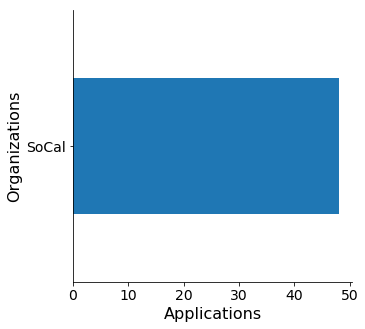

In [8]:
import pylab as plt
#orgs = apps.groupby("org").size()
orgs = apps[non_system_apps].groupby("org").size()
orgs.plot.barh(figsize=(5,5))
print(orgs)

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

plt.ylabel('')
plt.xlabel('Applications', fontsize=16)
plt.ylabel('Organizations', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)


# Apps per Environments (Spaces)
Spaces can be analagous to environments and based on the nomenclature there is a lot that can be inferred in a value analysis. Consistency between environments (buildpacks / rootfs), improved CI/CD (easier deployment commands across consisten environments), developer velociy with safety in mind (patch, upgrades, updates). 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text yticklabel objects>)

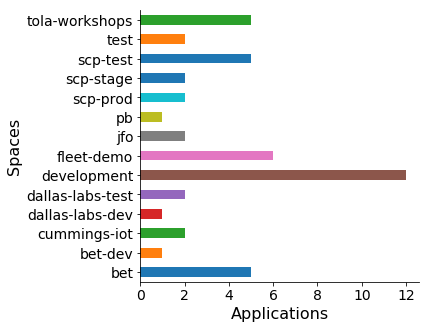

In [9]:
spaces = apps[non_system_apps].groupby("space").size()
spaces.plot.barh(figsize=(5,5))

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)

plt.ylabel('')
plt.xlabel('Applications', fontsize=16)
plt.ylabel('Spaces', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

# Interactive Analysis
This is an attempt to create interactive dahsboards so we can better explorer value to various customers

In [10]:
df_apps.head()

from ipywidgets import interactive
 
items = ['All']+sorted(apps['org'].unique().tolist())
 
def view(x=''):
    if x=='All': 
        display(apps)
    else:
        result = apps[apps['org']==x] 
        print ("Total Apps: {}".format(result['instances'].count()))
        display(result)

w = widgets.Select(options=items)
widgets.VBox([widgets.Label('Organizations'), interactive(view, x=w)])






# Developer Productivity - Application vs Days
## speed
Here we explore when was an application last updated comparing with the date the data was capture to infer speed. We should see an increase of deployments due to the automation of the platform. We can possibly measure developer productivity by comparing with how long releases took in the past or testing methodologies. 

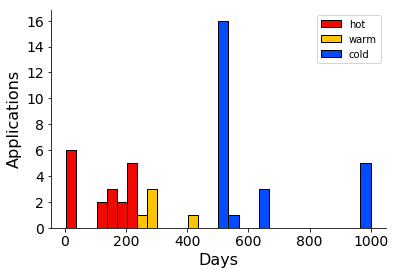

In [13]:
from matplotlib.patches import Rectangle

#d = datetime.datetime.strptime('2018-02-07T03:17:13Z', '%Y-%m-%dT%H:%M:%SZ')
def get_days(last_updated):
    if last_updated is not None:
        deltatime = capture_date - datetime.datetime.strptime(last_updated, '%Y-%m-%dT%H:%M:%SZ')
        return deltatime.days
    else:
        return 999

# df_non_system_apps['days'] = df_non_system_apps['updated'].apply(get_days)
app_days = df_non_system_apps['updated'].apply(get_days)

#app_days.plot.hist(bins=50)
N, bins, patches = plt.hist(app_days, 30, ec='k')

cmap = plt.get_cmap('jet')
hot = cmap(0.9)
warm =cmap(0.7)
cold = cmap(0.2)

for i in range(0,7):
    patches[i].set_facecolor(hot)
for i in range(7,14):
    patches[i].set_facecolor(warm)
for i in range(14,30):
    patches[i].set_facecolor(cold)

#create legend
handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [hot,warm, cold]]
labels= ["hot","warm", "cold"]
plt.legend(handles, labels)

plt.xlabel('Days', fontsize=16)
plt.ylabel('Applications', fontsize=16)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)

plt.gca().spines["top"].set_visible(False)  
plt.gca().spines["right"].set_visible(False)



In [14]:
app_days.describe()

count     48.000000
mean     407.187500
std      283.561818
min        4.000000
25%      197.750000
50%      517.000000
75%      523.000000
max      999.000000
Name: updated, dtype: float64

# Buildpack Distribution
This provides an few of the languages and frameworks used in the platform. This can be used in regards to saving on middleware license and support. There is also day 2 ops concepts on maintaining current versions and consistently patching across environments. This is usually a subset of the available buildpack on PCF. We can talk about innovation and enabling multi-language for modern microservices based development.

In [15]:
pd.DataFrame(df_non_system_apps.groupby("buildpack").size())


,0
buildpack,
client-certificate-mapper=1.2.0_RELEASE container-security-provider=1.8.0_RELEASE java-buildpack=[34mv4.5[0m-offline-https://github.com/cloudfoundry/java-buildpack.git#ffeefb9 java-main java-opts jvmkill-agent=1.10.0_RELEASE open-jdk-like-jre=1.8.0_1...,7
client-certificate-mapper=1.5.0_RELEASE container-security-provider=1.13.0_RELEASE java-buildpack=[34mv4.9[0m-offline-https://github.com/cloudfoundry/java-buildpack.git#830f4c3 java-opts java-security jvmkill-agent=1.12.0_RELEASE open-jdk-like-jre=1....,1
https://github.com/cloudfoundry/java-buildpack.git,6
https://github.com/cloudfoundry/java-buildpack.git#v3.8.1,9
https://github.com/cloudfoundry/staticfile-buildpack.git,1
java-buildpack=v3.8.1-offline-https://github.com/cloudfoundry/java-buildpack.git#29c79f2 java-main java-opts open-jdk-like-jre=1.8.0_91-unlimited-crypto open-jdk-like-memory-calculator=2.0.2_RELEASE spring-auto-reconfiguration=1.10.0_RELEASE,1
java-buildpack=v3.9-offline-https://github.com/cloudfoundry/java-buildpack.git#b050954 java-main open-jdk-like-jre=1.8.0_101 open-jdk-like-memory-calculator=2.0.2_RELEASE spring-auto-reconfiguration=1.10.0_RELEASE,1
java_buildpack,9
nodejs,1


Text(0,0.5,'')

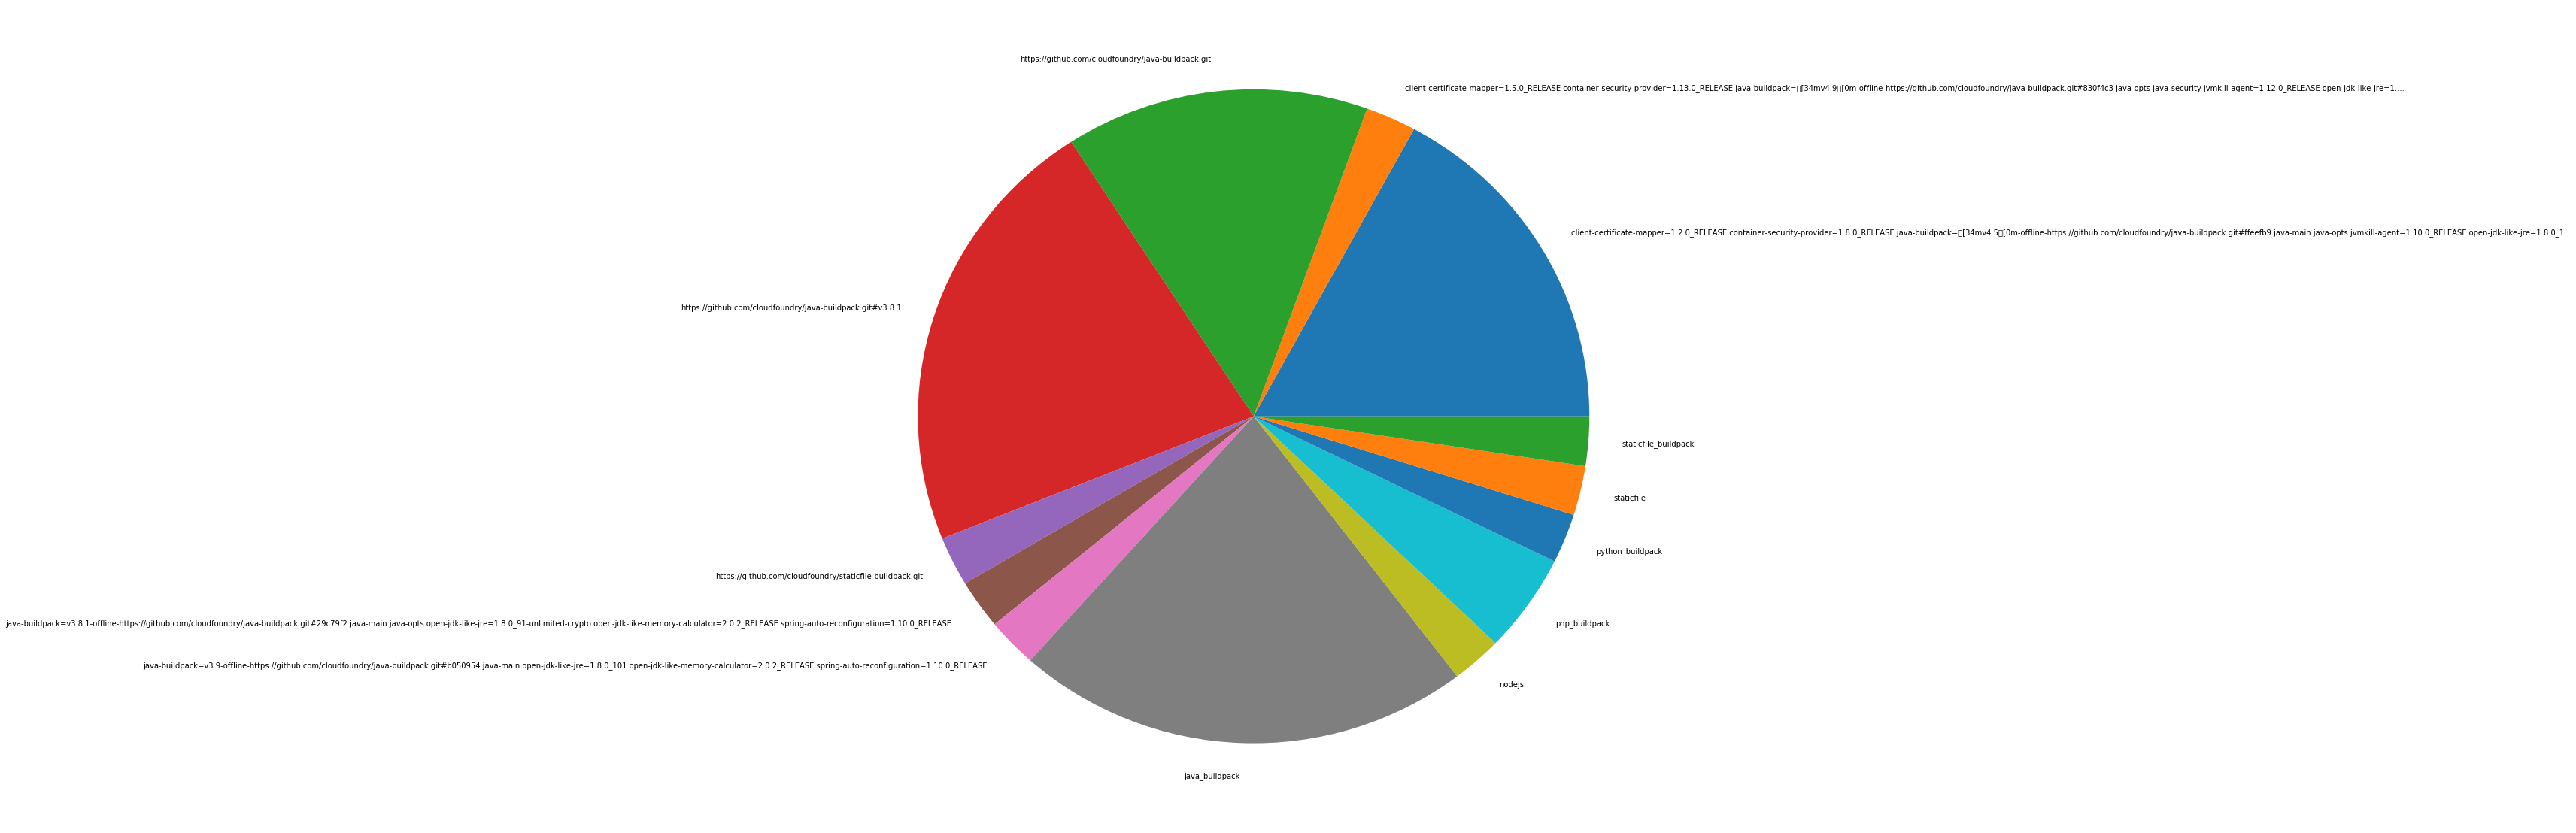

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches


buildpacks = df_non_system_apps.groupby("buildpack").size()

# buildpacks.plot.pie(figsize=(20,20), title="Buildpack Distribution")
buildpacks.plot.pie(figsize=(20,20))



plt.ylabel('')

# labels = df_apps['buildpack'].unique()

# handles = []
# for i, l in enumerate(labels):
#     handles.append(matplotlib.patches.Patch(color=plt.cm.Set3((i)/8.), label=l))
# plt.legend(handles,labels, bbox_to_anchor=(0.85,1.025), loc="upper left")

In [17]:
AI_memory = df_apps["memory"].sum()
AI_count = df_apps["instances"].sum()
unique_apps = len(apps['name'].unique())

print("Total Apps is {}".format(unique_apps))
print("Total AIs: {} consuming {} MB RAM".format(AI_count, AI_memory))


Total Apps is 42
Total AIs: 48 consuming 48512 MB RAM


# Services
Fast provisioning of data services, platform services like autoscaler, SSO or batch are often not easy to manage. The concept of a marketplace is huge for developer velocity who usually have to wait to get access to RDBMS or messaging systems. A lot of value to explor here.

Text(0,0.5,'')

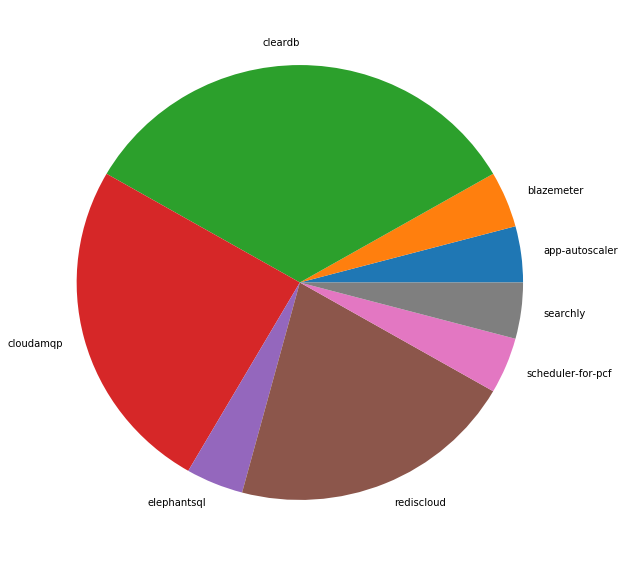

In [18]:

pd.DataFrame(df_service_instances.groupby("service_guid").size())

service_usage = services.groupby('label').size()

service_usage.plot.pie(figsize=(10,10))


plt.ylabel('')

In [19]:
service_usage

label
app-autoscaler       1
blazemeter           1
cleardb              8
cloudamqp            6
elephantsql          1
rediscloud           5
scheduler-for-pcf    1
searchly             1
dtype: int64